In [1]:
import pprint
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from qutip import *
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = os.getcwd()  # Gets the current working directory
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$

$$
H_0 = \hbar \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)} + \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{ij} \sigma_+^{(i)} \sigma_-^{(j)} \quad \text{,} \quad J_{ij} = \frac{\alpha}{|r_i - r_j|^3}
$$

$$
H_I = \hbar D \cdot E(t)
\quad \text{,} \quad D = \mu \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} + \sigma_-^{(i)}
\quad \text{,} \quad E(t_i) \propto \Omega_{coupling} \cos(\pi (t - t_i)) \delta(t_i)
$$

### Decay operators single case
$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

In [2]:
#
# Set the system parameters
#
# ENERGY LANDSCAPE, c = 1, hbar = 1
fixed_lam = 1. #
alpha     = 1. # coupling strength of the dipoles       Fine structure const?

omega_a   = 2 * np.pi / fixed_lam   # energysplitting of the atom, when ground state is set to 0
mu        = 1 * omega_a             # Dipole matrix element of each atom
omega_R   = 1 * omega_a             # Rabi freq coupling to laser field  for first 2 lasers  -> E_field_0 dot dot Dip_op, parallel

# LINBLAD OPS
gamma_0   = .1 # decay rate of the atoms
gamma_phi = .1 # dephasing rate of the atoms

# TOPOLOGY
n_chains = 1 # number of chains
n_rings  = 1 # number of rings
N_atoms  = n_chains * n_rings  # number of atoms

distance = 1. # * fixed_lam # defining topology

# TIME EVOLUTION
last_tau = 5 # * gamma_0
last_t = 1 * last_tau # last time when the system is measured -> t elem 0...last_det_t - T
t_steps = 40
tau_steps = t_steps
T_steps = t_steps // 2

times_t = np.linspace(0, last_t, t_steps) # list of times_t
times_tau = np.linspace(0, last_tau, tau_steps)  # list of times_t for tau
approx_T_vals = np.linspace(0, last_t, T_steps)  # approximate T values
T_indices = np.array([np.abs(times_t - x).argmin() for x in approx_T_vals])
times_T = times_t[T_indices]

#times = times_tau + times_T + times_t

print(times_tau, times_T, times_t)

mean_pos = [0, 0, 0]  # Mean position (can be any point in 3D space)
sigma_pos = N_atoms / 10  # Standard deviation for position distribution
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos
def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])
def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos
def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos
##################                           help functions                                 ##################
def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer
tolerance = count_decimal_digits(times_t[1]) - 2
def truncate_number(number, decimals=0):
    factor = 10.0 ** decimals
    return int(number * factor) / factor
def heaviside(x):
    return 1 if x >= 0 else 0
def sample_positions(mean_pos, sigma_pos, N_atoms):
    positions = []
    while len(positions) < N_atoms:
        # Sample a new position for the atom
        new_position = np.random.normal(loc=mean_pos, scale=sigma_pos, size=3)
        # Check if the new position is unique (no duplicates)
        if not any(np.allclose(new_position, pos) for pos in positions):
            positions.append(new_position)
    return np.array(positions)
def sample_frequencies(E0, Delta, N_atoms):
    # Sample N_atoms frequencies from the Gaussian distribution
    frequencies = np.random.normal(loc=E0, scale=Delta/2, size=N_atoms)
    return frequencies
def plot_positive_color_map(x, y, data, T = np.inf, space="real", type="real", positive=False, safe=False, output_dir=None, fixed_lam=None, alpha=None, gamma_0=None, gamma_phi=None, n_rings=None, n_chains=None, distance=None):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        x (np.array): 1D array of x values.
        y (np.array): 1D array of y values.
        data (np.array): 2D array of data values aligned with x and y.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.

    Returns:
        None
    """
    # Convert x and y into 1D arrays if they're not
    x = np.array(x)
    y = np.array(y)

    if positive:
        # Filter for positive x and y values
        positive_x_indices = np.where(x > 0)[0]  # Indices where x > 0
        positive_y_indices = np.where(y > 0)[0]  # Indices where y > 0
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    if space == "real":
        colormap = "viridis"
        label = r"$E_{out} \propto P / E_0$"
        title = f"Real space 2D Spectrum (arb. units)"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{det}$ (arb. units)"
        y_title = r"$\tau_{coh}$ (arb. units)"
    elif space == "freq":
        if type == "real":
            title = f"Freq space, Real 2D Spectrum (arb. units)"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum (arb. units)"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum (arb. units)"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum (arb. units)"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        colormap = "plasma"
        label = r"$E_{out} \propto P / E_0$"
        if T != np.inf:
            title += f" at T ={T:.2f}"

        x_title = r"$\omega_{t_{det}}$ (arb. units)"
        y_title = r"$\omega_{\tau_{coh}}$ (arb. units)"

    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Check and adjust the dimensions of x, y, and data
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Add 1 to the dimensions of x and y for correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  # Add an extra value for the last x edge
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])  # Add an extra value for the last y edge

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / omega_R, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True
    if safe and output_dir is not None:
        file_name_combined = (
            f"Classical_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_"
            f"{n_rings}x{n_chains}_dist={distance:.2f}_positive={positive}_space={space}"
        )
        if space == "freq":
            file_name_combined += f"_type={type}"
        file_name_combined += ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)

    plt.show()
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains) # sample_positions(mean_pos, sigma_pos, N_atoms)        #
    atom_frequencies = sample_frequencies(omega_a, 0.0125 * omega_a, N_atoms) # [omega_a] * N_atoms #
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += atom_frequencies[a] *op # Diagonals except for |0><0|
    return H
def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = np.exp(1j*(args['omega'] * t + args['phi']))
    E += np.conjugate(E)
    # secure the field is 0 outside short range
    E *= np.cos(np.pi * (t - t0) / (2 * Delta))**2 * heaviside(t - (t0 - Delta)) * heaviside(t0 + Delta - t)

    return args['E0'] * E

# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]
# initial state
psiini = atom_g # = |g>_atom

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0         # collective sigma_x operator for the system
for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    Dip_op += mu * op + mu * op.dag()
H0 = Hamilton0(distance, n_rings, n_chains)

# Jump / Expect Operators          # Define the decay collapse and dephasing operator for each spin
# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in sm_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in sm_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators
# Expectation operators for measuring populations across atomic ground and excited levels
e_op_list = [ket2dm(basis(N_atoms + 1, i)) for i in range(N_atoms + 1)]

#
# evolution with t
#
# create the time dependant evolution
Omegas = [omega_R, omega_R, omega_R/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]    # The laser is on resonant
Delta_ts = [last_t/1000, last_t/1000, last_t/1000] # narrow width of the pulses
HI = [-Dip_op, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]

options = Options(store_states=True)


#
# PREPROCESSING
#
# Phase cycling
phases = [0]#[-1 * i * np.pi / 2 for i in range(4)]

[0.         0.12820513 0.25641026 0.38461538 0.51282051 0.64102564
 0.76923077 0.8974359  1.02564103 1.15384615 1.28205128 1.41025641
 1.53846154 1.66666667 1.79487179 1.92307692 2.05128205 2.17948718
 2.30769231 2.43589744 2.56410256 2.69230769 2.82051282 2.94871795
 3.07692308 3.20512821 3.33333333 3.46153846 3.58974359 3.71794872
 3.84615385 3.97435897 4.1025641  4.23076923 4.35897436 4.48717949
 4.61538462 4.74358974 4.87179487 5.        ] [0.         0.25641026 0.51282051 0.76923077 1.02564103 1.28205128
 1.53846154 1.79487179 2.05128205 2.30769231 2.69230769 2.94871795
 3.20512821 3.46153846 3.71794872 3.97435897 4.23076923 4.48717949
 4.74358974 5.        ] [0.         0.12820513 0.25641026 0.38461538 0.51282051 0.64102564
 0.76923077 0.8974359  1.02564103 1.15384615 1.28205128 1.41025641
 1.53846154 1.66666667 1.79487179 1.92307692 2.05128205 2.17948718
 2.30769231 2.43589744 2.56410256 2.69230769 2.82051282 2.94871795
 3.07692308 3.20512821 3.33333333 3.46153846 3.58974359 3.7

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [3]:
#
# CALCULATIONS
#

# (first laser pulse)
times_0 = times_tau# np.linspace(0, last_pulse, time_steps) # list of times_t

# Iterate over the phi values
def compute_first_pulse(phi_1):
    # Set the arguments for this particular phi
    args_0 = {
        'phi': phi_1,
        'time': times_0[0] + Delta_ts[0],
        'omega': omegas[0],
        'Delta': Delta_ts[0],
        'E0': Omegas[0]
    }

    # Solve the system using mesolve
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, e_ops=e_op_list, args=args_0, options=options)

    # Prepare the data dictionary for this particular phi value
    list_0 = []
    for i in range(1, len(times_0)):
        list_0.append(result_0.states[i])
    return list_0

def compute_second_pulse(phi_2, res_1):
    list_1 = []

    for i, psiini_1 in enumerate(res_1):
        times_1 = times_tau +  times_0[i] (This should be a pointwise addition, so for every element in times_T -> times_t[i] is added)

        # calc the second pulse evolution
        args_1 = {
            'phi': phi_2,  # Use phi_2 for the second pulse
            'time': times_1[0] + Delta_ts[1],
            'omega': omegas[1],
            'Delta': Delta_ts[1],
            'E0': Omegas[1]
        }
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, e_ops=e_op_list, args=args_1, options=options)

        local_list = []
        for j in range(1, len(times_1)):
            local_list.append(result_1.states[j])

        if local_list:  # Check if the listionary is not empty
            list_1[i] = local_list
    return list_1

def compute_third_pulse(res_2):
    data_list = []
    for i, dic1 in res_2:
        times_1 = times_tau[i]
        count = 0
        # Iterate over the T values (waiting times) and calculate the last laser pulse
        for j, psiini_2 in dic1:

            T_j = times_1[j] + Delta_ts[2] - times_1[0] - Delta_ts[1]  # waiting_time_j
            T_j = truncate_number(T_j, tolerance - 2)
            T_c = truncate_number(times_T[count], tolerance - 2)
            # if the delay T is smaller than the current pulse difference, take next one
            while T_c < T_j and count < len(times_T) - 1:
                count += 1
                T_c = truncate_number(times_T[count], tolerance - 2)

            # ONLY NOW MAKE THE LAST PULSE
            if np.isclose(T_j, T_c):

                times_2 = times_1[0] + T_j + times_t

                # Define the parameters for the last laser pulse
                args_2 = {
                    'phi': 0,  # Last pulse has no phase kick
                    'time': times_2[0] + Delta_ts[2],  # Duration for the 2nd pulse
                    'omega': omegas[2],  # Omega for the 2nd pulse
                    'Delta': Delta_ts[2],  # Delta for the 2nd pulse
                    'E0': Omegas[2]  # E0 for the 2nd pulse
                }

                # Solve the system using mesolve for the last pulse
                result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, e_ops=e_op_list, args=args_2, options=options)

                # Iterate over the states in result_2 and store the ones that meet the condition
                for k in range(len(times_2)):
                    if (times_1[j] + 2 * Delta_ts[2] <= times_2[k] <= last_det_t):
                        tau_i = times_1[0] + Delta_ts[1] - Delta_ts[0]
                        t_k = times_2[k] - times_2[0] - Delta_ts[2]
                        tau_i = truncate_number(tau_i, tolerance - 2)
                        t_k = truncate_number(t_k, tolerance - 2)

#                        if j not in data_list:
#                            data_list[j] = []
#                        if tau_i not in data_list[j]:
#                            data_list[j][i] = []
#                        if k not in data_list[j][i]:
#                            data_list[j][i][k] = []
#                        # Compute the polarization and store it in the listionary
#                        Polarization = expect(Dip_op, result_2.states[k])
#                        data_list[j][i][k] = Polarization

                        # Compute the polarization and store it in the listionary
                        Polarization = expect(Dip_op, result_2.states[k])
                        data_list[T_j][tau_i][t_k] = Polarization
    pprint.pprint(data_list)
    return data_list
# TEST
#x = compute_first_pulse(0)
#y = compute_second_pulse(0, x)
#z = compute_third_pulse(y)
def process_phi_combination(phi_1, phi_2):
    # Wrapper function to process each combination of phi_1 and phi_2
    data = 0
    # Step 1: Compute the first pulse for phi_1
    first_pulse_data = compute_first_pulse(phi_1)

    # Step 2: Compute the second pulse with the result from the first pulse
    second_pulse_data = compute_second_pulse(phi_2, first_pulse_data)

    # Step 3: Compute the third pulse with the result from the second pulse
    data = compute_third_pulse(second_pulse_data)
    return data

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1452005042.py, line 32)

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_3921/569296777.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Normalized Energy (E / $\omega_a$)')


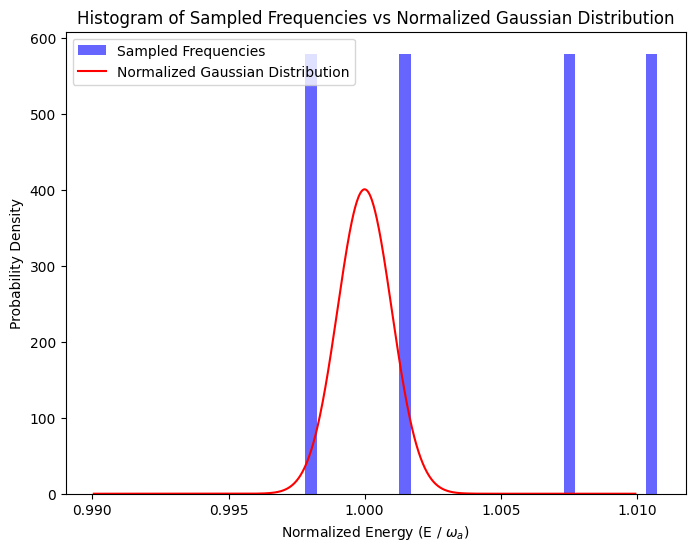

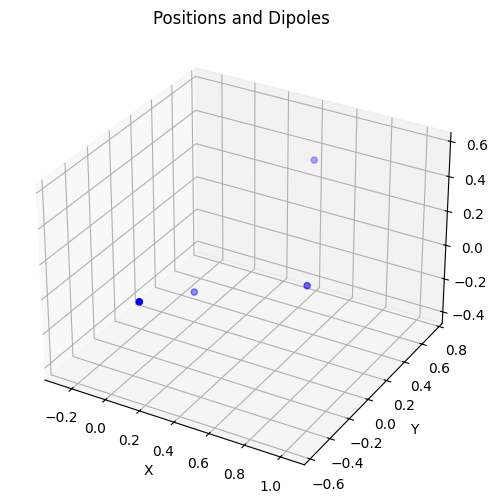

In [122]:
# Sample frequencies for each atom
atom_frequencies = sample_frequencies(1, Delta, N_atoms)

plt.figure(figsize=(8, 6))
E_normalized = np.linspace(omega_a - 5 * Delta, omega_a + 5 * Delta, 1000) / omega_a
sigma_normalized = Delta / (2 * omega_a)  # Standard deviation in normalized units
P_normalized = (1 / (sigma_normalized * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((E_normalized - 1) / sigma_normalized)**2)
plt.hist(atom_frequencies, bins=30, density=True, alpha=0.6, color='blue', label='Sampled Frequencies')
plt.plot(E_normalized, P_normalized, label=r'Normalized Gaussian Distribution', color='red')
plt.title('Histogram of Sampled Frequencies vs Normalized Gaussian Distribution')
plt.xlabel('Normalized Energy (E / $\omega_a$)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Pos = cyl_positions(distance, N_atoms, n_chains)
Pos = sample_positions(mean_pos, sigma_pos, N_atoms)

# vizualizing the atomic positions
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [123]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0         # collective sigma_x operator for the system
for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    Dip_op += mu * op + mu * op.dag()

In [136]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains) # sample_positions(mean_pos, sigma_pos, N_atoms)        #
    atom_frequencies = sample_frequencies(omega_a, 0.0125 * omega_a, N_atoms) # [omega_a] * N_atoms #
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += atom_frequencies[a] *op # Diagonals except for |0><0|
    return H
H0 = Hamilton0(distance, n_rings, n_chains)
H0

Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.         0.        ]
 [0.         6.26986207 1.         1.         0.35355339]
 [0.         1.         6.25577333 0.35355339 1.        ]
 [0.         1.         0.35355339 6.32404296 1.        ]
 [0.         0.35355339 1.         1.         6.30476348]]

In [137]:
# Jump / Expect Operators          # Define the decay collapse and dephasing operator for each spin
op_list = sm_list  # atomic lowering operators (sm)

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in op_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in op_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic ground and excited levels
e_op_list = [ket2dm(basis(N_atoms + 1, i)) for i in range(N_atoms + 1)]

In [138]:
# evolution with t
# initial state
psiini = basis(N_atoms+1, 0) # = |g>_atom

# create the time dependant evolution
Omegas = [omega_R, omega_R, omega_R/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]    # The laser is on resonant
Delta_ts = [last_pulse/time_steps, last_pulse/time_steps, last_pulse/time_steps] # narrow width of the pulses

def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = np.exp(1j*(args['omega'] * t + args['phi']))
    E += np.conjugate(E)
    # secure the field is 0 outside short range
    E *= np.cos(np.pi * (t - t0) / (2 * Delta))**2 * heaviside(t - (t0 - Delta)) * heaviside(t0 + Delta - t)

    return args['E0'] * E

HI = [-Dip_op, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]

options = Options(store_states=True)

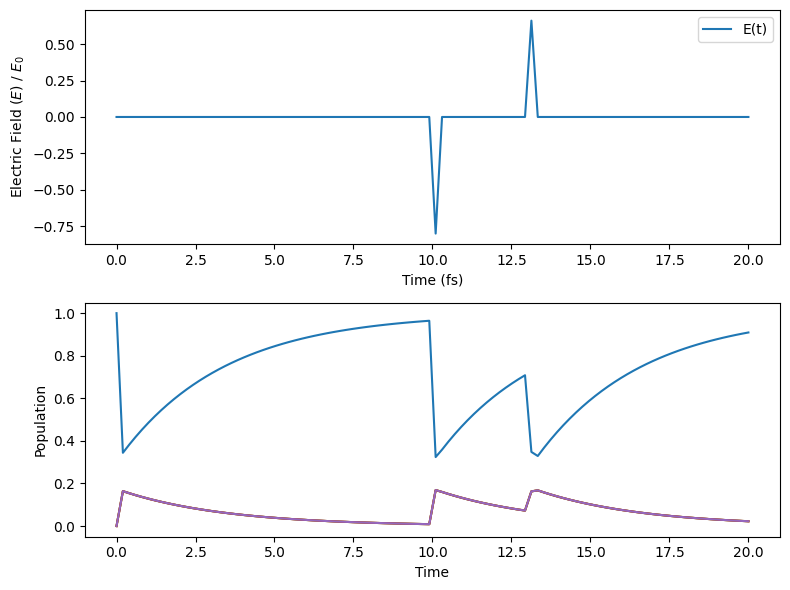

In [127]:
#
# VIZUALIZE THE FIELD AS AN EXAMPLE
#
phi12 = 1
args_0 = {
    'phi': phi12,
    'time': Delta_ts[0],
    'omega': omegas[0],
    'Delta': Delta_ts[0],
    'E0': Omegas[0]
}
args_1 = {
    'phi': phi12,
    'time': 10 + Delta_ts[1],
    'omega': omegas[1],
    'Delta': Delta_ts[1],
    'E0': Omegas[1]
}
args_2 = {
    'phi': 0,
    'time': 3 + 10 + Delta_ts[2],
    'omega': omegas[2],
    'Delta': Delta_ts[2],
    'E0': Omegas[2]
}

times_test = np.linspace(0,20, 100)
def El_test(t, args):
    args_0 = args["args_0"]
    args_1 = args["args_1"]
    args_2 = args["args_2"]
    return El_field(t, args_0) + El_field(t, args_1) + El_field(t, args_2)

args_test = {"args_0": args_0, "args_1": args_1, "args_2": args_2}
E_test = [El_test(t, args_test) for t in times_test]
HI_test = [-Dip_op, El_test] # interaction Hamiltonian with function-based time dependence
H_test = [H0, HI_test]

# Plot the electric field over time
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(times_test, E_test, label="E(t)")
ax[0].set_xlabel("Time (fs)")
ax[0].set_ylabel("Electric Field ($E$) / $E_0$")
ax[0].legend()

result = mesolve(H_test, psiini, times_test, c_ops=c_op_list, e_ops=e_op_list, args=args_test, options=options)
# Plot expectation values (example for population dynamics)
for i, e_op_expect in enumerate(result.expect):
    label = f"$\\langle |e_{i}| \\rangle$" if i else r"$\langle |g| \rangle$"
    ax[1].plot(times_test, result.expect[i], label=label)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Population")
#ax[1].legend()
plt.tight_layout()
plt.show()

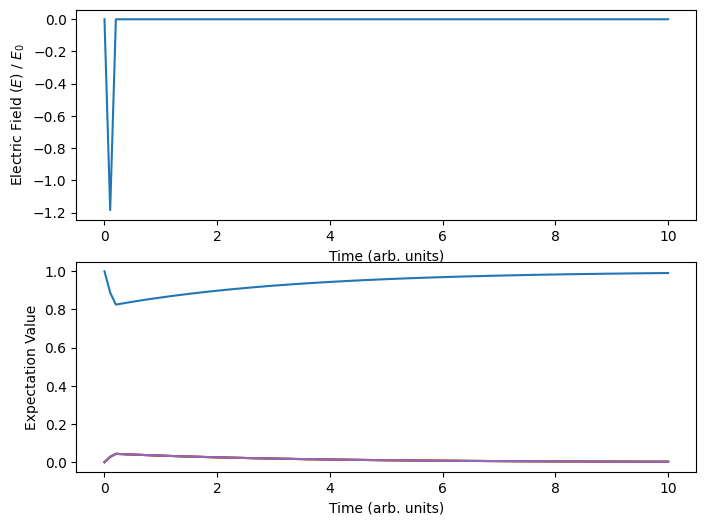

In [128]:
#
# PREPROCESSING
#
# Phase cycling
phases = [-1 * i * np.pi / 2 for i in range(4)]
data_dict_stage1 = {}
for phi in phases:
    data_dict_stage1[phi] = {}
#
# CALCULATIONS
#

# (first laser pulse)
times_0 = times_t

# Iterate over the phi values
for phi in data_dict_stage1:
    args_0 = {
        'phi': phi,  # Use the phase 0
        'time': Delta_ts[0],  # t0 value = Delta value such that the pulse immediatley starts
        'omega': omegas[0],  # omega value
        'Delta': Delta_ts[0], # The width should be
        'E0': Omegas[0]  # E0 value
    }
    # Solve the system using mesolve (first laser pulse)
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, e_ops=e_op_list, args=args_0, options=options)

    current_dict = {}

    for i in range(len(times_0)): # save only the states that make sense
        if (2 * Delta_ts[0] <= times_0[i] <= last_pulse - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]  # tau is indirectly stored in the index i (key of the dictionary)
            #print(expect(Dip_op, result_0.states[i]))

    if current_dict:  # Check if the dictionary is not empty
        data_dict_stage1[phi] = current_dict

#
# PLOT TO CHECK the evolution
#
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(times_0, [El_field(t, args_0)/omega_R for t in times_0])
ax1.set_xlabel("Time (arb. units)")
ax1.set_ylabel("Electric Field ($E$) / $E_0$")
for i, e_op_expect in enumerate(result_0.expect):
    if i == 0:
        label = r"$|g>_{at}$"
    else:
        label = f"$|e>_{i}$"
    ax2.plot(result_0.times, e_op_expect, label=label)
ax2.set_xlabel("Time (arb. units)")
ax2.set_ylabel("Expectation Value")
#ax2.legend()
plt.show()

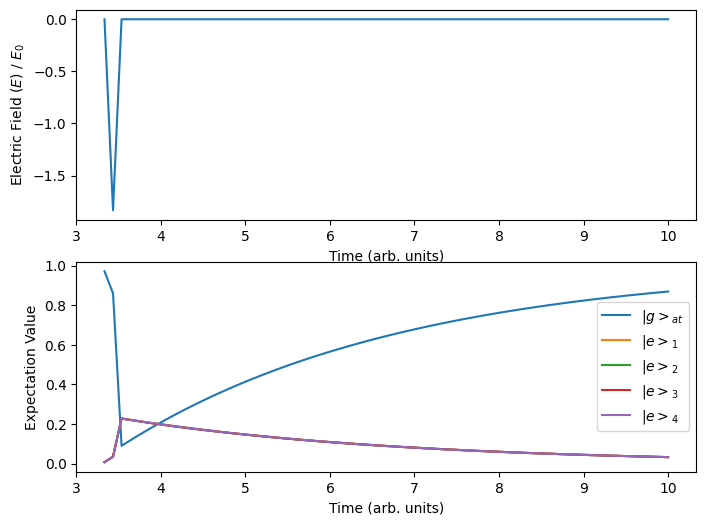

In [129]:
# (second laser pulse with combinations of phi_1 and phi_2)
data_dict_stage2 = {}

# Iterate over the phi_1 values (from the first pulse)
for phi_1, dic in data_dict_stage1.items():
    data_dict_stage2[phi_1] = {}  # Initialize entry for phi_1
    for phi_2 in phases:  # Iterate over all possible phi_2 values for the second pulse
        data_dict_stage2[phi_1][phi_2] = {}  # Initialize entry for phi_2 within phi_1

        # Iterate over the tau values and states after tau, from there make the second laser pulse
        for i, psiini_1 in dic.items():
            times_1 = times_t[i:]
            args_1 = {
                'phi': phi_2,  # Use phi_2 for the second pulse
                'time': times_1[0] + Delta_ts[1],
                'omega': omegas[1],
                'Delta': Delta_ts[1],
                'E0': Omegas[1]
            }
            # Solve the system using mesolve (second laser pulse)
            result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, e_ops=e_op_list, args=args_1, options=options)

            current_dict = {}
            for j in range(len(times_1)):  # Save only the states that make sense
                if (times_t[i] + 2 * Delta_ts[1] <= times_1[j] <= last_pulse - 2 * Delta_ts[2]):
                    current_dict[j] = result_1.states[j]  # T is stored in the information j, alongside i

            if current_dict:  # Check if the dictionary is not empty
                # Save results under the current combination of phi_1 and phi_2
                data_dict_stage2[phi_1][phi_2][i] = current_dict

            # Plot one example (optional to verify correctness)
            if phi_1 == phases[0] and phi_2 == phases[0] and i == time_steps // 3:
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
                ax1.plot(times_1, [El_field(t, args_1) / omega_R for t in times_1])
                ax1.set_xlabel("Time (arb. units)")
                ax1.set_ylabel("Electric Field ($E$) / $E_0$")
                for idx, e_op_expect in enumerate(result_1.expect):
                    if idx == 0:
                        label = r"$|g>_{at}$"
                    else:
                        label = f"$|e>_{idx}$"
                    ax2.plot(result_1.times, e_op_expect, label=label)
                ax2.set_xlabel("Time (arb. units)")
                ax2.set_ylabel("Expectation Value")
                ax2.legend()
                plt.show()

In [130]:
# (third laser pulse)
data_dict = {}

# Iterate over the phi_1 values
for phi_1, dic in data_dict_stage2.items():
    if phi_1 not in data_dict:
        data_dict[phi_1] = {}

    # Iterate over the phi_2 values
    for phi_2, dic2 in dic.items():
        if phi_2 not in data_dict[phi_1]:
            data_dict[phi_1][phi_2] = {}

        # Iterate over the tau values
        for i, dic1 in dic2.items():

            times_1 = times_t[i:]
            # Iterate over the T values and make the last laser pulse
            for j, psiini_2 in dic1.items():
                count = 0
                T_j = times_1[j] + Delta_ts[2] - times_1[0] - Delta_ts[1]  # waiting_time_j
                T_j = truncate_number(T_j, tolerance - 2)
                T_c = times_T[count]
                # if the delay T is smaller than the current pulse difference, take next one
                while T_c < T_j:
                    count += 1
                    T_c = truncate_number(times_T[count], tolerance - 2)

                # ONLY NOW MAKE THE LAST PULSE
                if np.isclose(T_j, T_c):

                    # (last laser pulse)
                    times_2 = times_1[j:]
                    args_2 = {
                        'phi': 0,  # last pulse has no phase kick
                        'time': times_2[0] + Delta_ts[2],  # Duration for the 2nd pulse
                        'omega': omegas[2],  # Omega for the 2nd pulse
                        'Delta': Delta_ts[2],  # Delta for the 2nd pulse
                        'E0': Omegas[2]  # E0 for the 2nd pulse
                    }
                    result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, e_ops=e_op_list, args=args_2,
                                       options=options)

                    # Iterate over the states in result_2 and store the ones that meet the condition below:
                    for k in range(len(times_2)):
                        if (times_1[j] + 2 * Delta_ts[2] <= times_2[k] <= last_det_t):

                            tau_i = times_0[i] + Delta_ts[1] - Delta_ts[0]
                            t_k = times_2[k] - times_2[0] - Delta_ts[2]
                            tau_i = truncate_number(tau_i, tolerance - 2)
                            t_k = truncate_number(t_k, tolerance - 2)

                            if T_j not in data_dict[phi_1][phi_2]:
                                data_dict[phi_1][phi_2][T_j] = {}
                            if tau_i not in data_dict[phi_1][phi_2][T_j]:
                                data_dict[phi_1][phi_2][T_j][tau_i] = {}
                            Polarization = expect(Dip_op, result_2.states[k]) / omega_R
                            data_dict[phi_1][phi_2][T_j][tau_i][t_k] = Polarization

In [131]:
#
# POST-PROCESSING
#
# Create an empty dictionary `averaged_data_dict` to store expectation values for each (T_j, tau_i, t_k):
averaged_data_dict = {}

# Iterate over T_j
for T_j in data_dict[next(iter(data_dict))][next(iter(data_dict[next(iter(data_dict))]))].keys():
    if T_j not in averaged_data_dict:
        averaged_data_dict[T_j] = {}

    # Iterate over tau_i for the given T_j
    for tau_i in data_dict[next(iter(data_dict))][next(iter(data_dict[next(iter(data_dict))]))][T_j].keys():
        if tau_i not in averaged_data_dict[T_j]:
            averaged_data_dict[T_j][tau_i] = {}

        # Iterate over t_k for the given T_j and tau_i
        for t_k in data_dict[next(iter(data_dict))][next(iter(data_dict[next(iter(data_dict))]))][T_j][tau_i].keys():
            # Sum over both phi_1 and phi_2 to create the mean state
            mean_Polarization = (sum(
                data_dict[phi_1][phi_2][T_j][tau_i][t_k]
                for phi_1 in data_dict.keys()
                for phi_2 in data_dict[phi_1].keys())
            / (len(data_dict) * len(next(iter(data_dict.values())))))

            # Calculate the expectation value for the mean state of the dipole operator
            averaged_data_dict[T_j][tau_i][t_k] = mean_Polarization

In [132]:
#
# PREPARE FOR PLOTTING
#
T_dictionary = {}

for T in sorted(averaged_data_dict.keys()):  # Extract all unique T values
    taus = np.array(list(averaged_data_dict[T].keys()))
    ts = np.array(sorted(set(t for tau in taus for t in averaged_data_dict[T][tau].keys())))
    data = np.zeros((len(ts), len(taus)))  # or dtype=np.complex128 if needed
    # Populate the 2D data array with the corresponding expect_vals
    for i, t in enumerate(ts):  # Iterate over ts
        for j, tau in enumerate(taus):  # Iterate over taus
            # Check if the specific t exists for the given tau
            if t in averaged_data_dict[T][tau]:
                data[i, j] = averaged_data_dict[T][tau][t]  # Assign expect_val

    # Store T-specific results in the dictionary
    T_dictionary[T] = {
        "ts": ts,      # Local ts specific to T
        "taus": taus,  # Local taus specific to T
        "data": data,  # Local data
    }

valid_indices = np.linspace(0, time_steps - 1, time_steps//3, dtype=int)  # Equally distributed indices

smallest_key = min(averaged_data_dict.keys())  # first T value gives biggest data-set
global_ts = np.array(T_dictionary[smallest_key]["ts"])  # Local taus for the current T
global_taus = np.array(T_dictionary[smallest_key]["taus"])  # Local taus for the current T

global_t_freqs = (np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))  # Frequency axis for detection time
global_tau_freqs = (np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))  # Frequency axis for excitation time


# Sum all data into global sum
global_data = np.zeros((len(global_ts), len(global_taus)))

T_dictionary_full_real = {} # save the extended time dim. data in new dict
T_dictionary_full_freq = {} # save the extended freq dim. data in new dict
for T, T_data in T_dictionary.items():
    # Initialize the global extended grid with zeros
    data_extended = np.zeros((len(global_ts), len(global_taus)))
    # Extract data for the current T
    taus = T_data["taus"]  # Local taus for the current T
    ts = T_data["ts"]  # Local ts for the current T
    data = T_data["data"]  # Aligned 2D data
    if len(ts) < 4 or len(taus) < 4:  # Ensure only valid indices are selected
        continue

    # Map taus and ts to global indices
    for i, t in enumerate(ts):
        for j, tau in enumerate(taus):
            global_i = np.where(global_ts == t)[0]  # Find the index of t in global_ts
            global_j = np.where(global_taus == tau)[0]
            data_extended[global_i, global_j] = data[i, j]  # Accumulate (you can also do averaging if needed)
    max = np.max(np.abs(data_extended))
    data_extended /= max

    #plot_positive_color_map(global_ts, global_taus, data_extended)
    T_dictionary_full_real[T] = {"data": data_extended}
    T_dictionary_full_freq[T] = {"data": np.fft.fft2(data_extended)}

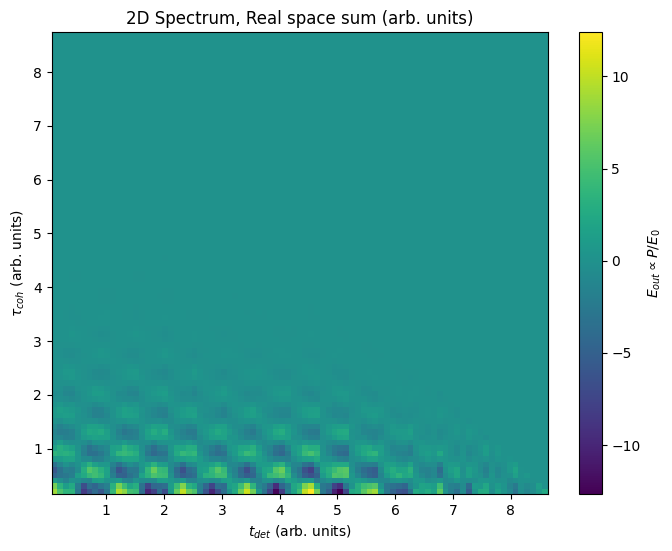

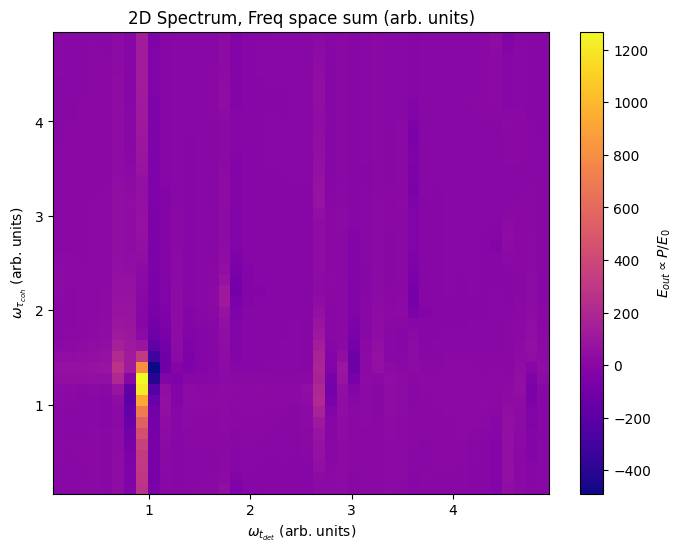

In [135]:
#
# PLOT THE WHOLE DATA AVG and its FT
#

# Sum data for each temperature T in T_dictionary
for T, T_data in T_dictionary.items():
    ts = T_data["ts"]
    taus = T_data["taus"]
    data = T_data["data"]

    for i, t in enumerate(ts):
        for j, tau in enumerate(taus):
            global_i = np.where(global_ts == t)[0]  # Find the index of t in global_ts
            global_j = np.where(global_taus == tau)[0]
            global_data[global_i, global_j] += data[i, j]  # Accumulate (you can also do averaging if needed)
max = np.max(np.abs(global_data))
plot_positive_color_map(global_ts, global_taus, global_data, T, sum = True, safe = False)

# Perform 2D Fourier Transform
ft_data = np.fft.fft2(global_data)
plot_positive_color_map(global_t_freqs, global_tau_freqs, ft_data, T, sum = True, space = "freq", type = "abs", positive = True, safe = False)
file_name_combined = f"Classical_REAL_+_FT_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_{n_rings}x{n_chains}_dist={distance:.2f}.svg"
save_path_combined = "/home/leopold/PycharmProjects/Master_thesis/Figures_From_Python/" + file_name_combined
#plt.savefig(save_path_combined)

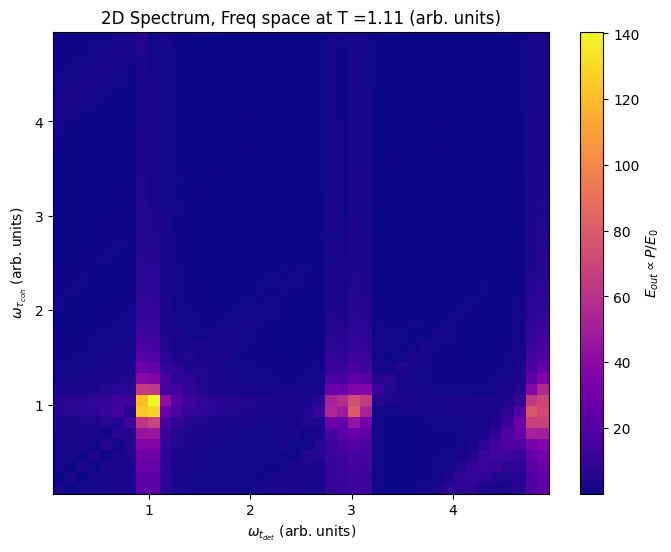

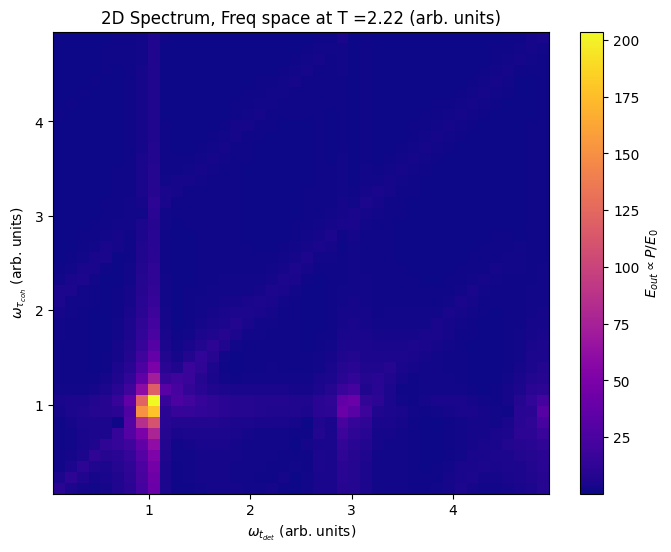

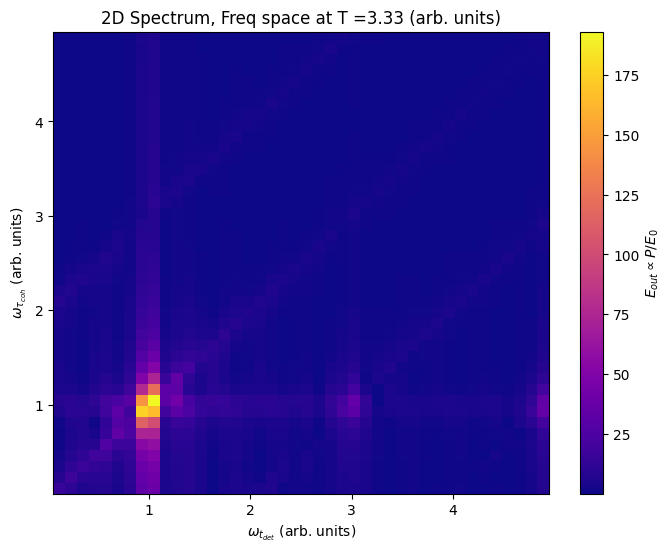

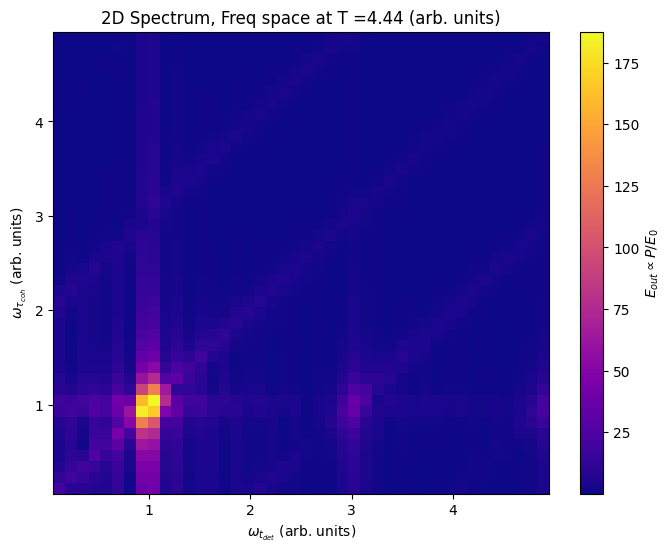

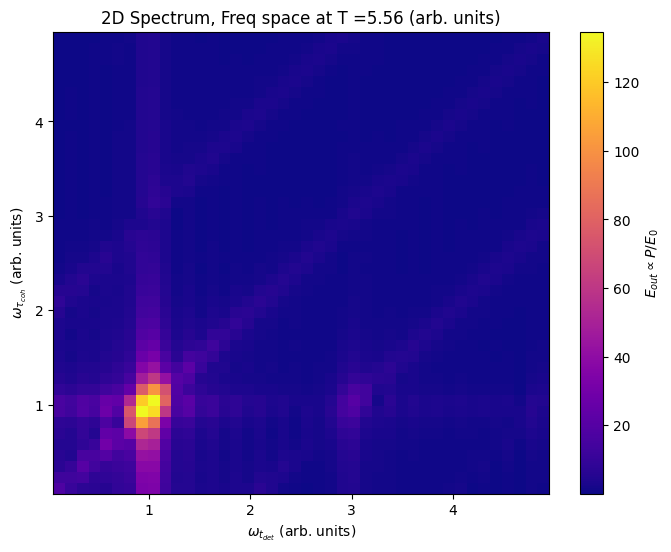

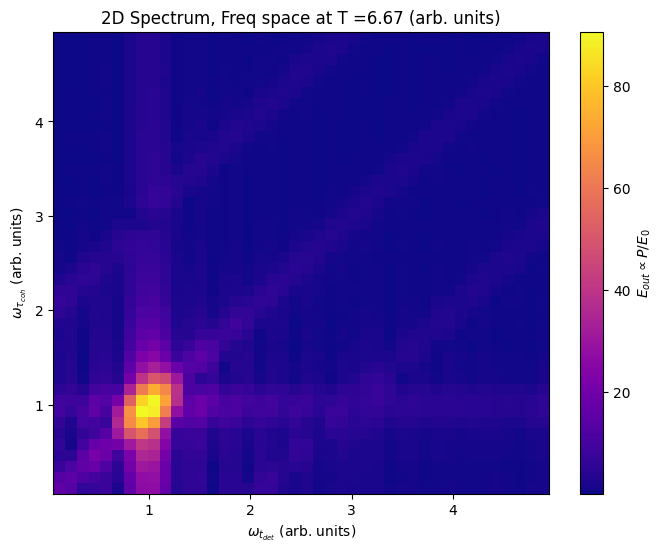

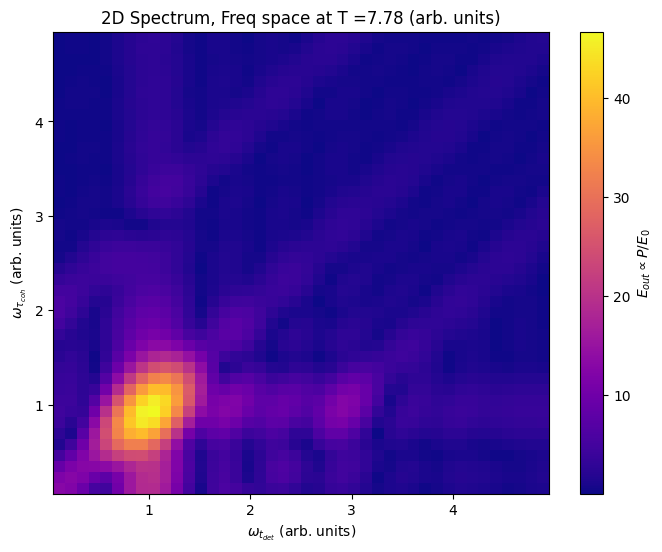

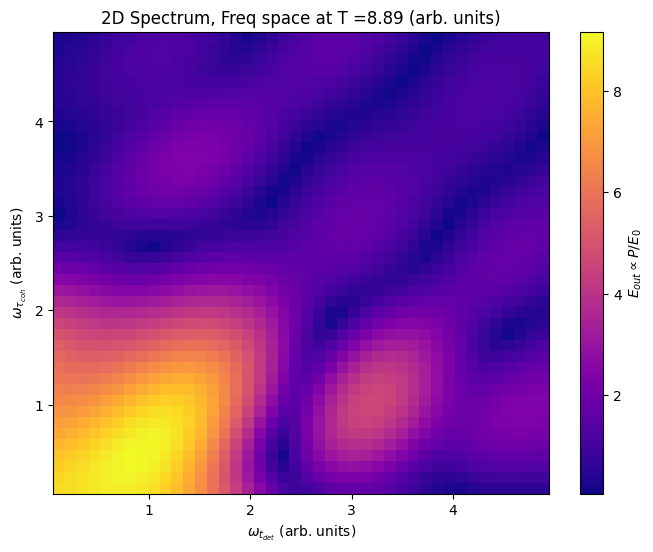

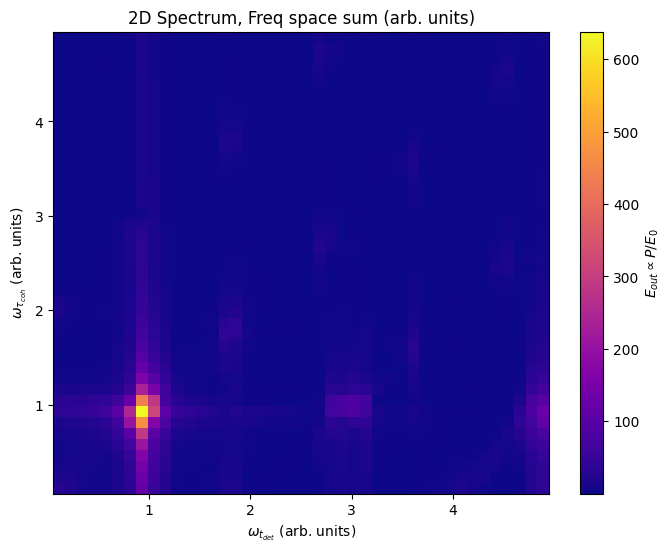

In [105]:
#
# PLOT THE TIME DIMENSIONS ON A GLOBAL GRID
#
summed_freq_data = 0
#
# PLOT THE GLOBAL DATA IN FREQUENCY SPACE AND THE SUM
#
for T in T_dictionary_full_real.keys():
    T_data_time = T_dictionary_full_real[T]
    T_data_freq = T_dictionary_full_freq[T]
    data_time = T_data_time["data"]  # Aligned 2D data
    data_freq = T_data_freq["data"]  # Aligned 2D data
    summed_freq_data += data_freq

    #plot_positive_color_map(global_ts, global_taus, (data_time), T, space = "real", safe = False)
    plot_positive_color_map(global_t_freqs, global_tau_freqs, (data_freq), T, space = "freq", type = "abs", positive = True, safe = False)
    

max = np.max(np.abs(summed_freq_data))
#summed_freq_data /= max
plot_positive_color_map(global_t_freqs, global_tau_freqs, (summed_freq_data), T, sum = True, space = "freq", type = "abs", positive = True, safe = False)